# RDF fitting

This tutorial runs through some of the functionality that can be used to determine solvation radii from the RDF. Both the default functionality and the use of custom functions to determine the radii from the RDF are covered.

It is recommended that you run through the **basics tutorial** in the **basics_tutorial.ipynb** notebook before getting started with this tutorial.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

from solvation_analysis.rdf_parser import plot_scipy_find_peaks_troughs, identify_cutoff_scipy
from solvation_analysis.tests import datafiles
from solvation_analysis.solution import Solution

from scipy.signal import find_peaks

Lets make a convenience function to allow us to quickly load a precomputed RDF from a `.npz` file

In [3]:
def npz_loader(npz):
    arr = list(np.load(npz).values())[0]
    return arr

Now lets use the functionality in `solvation_analysis.rdf_parser` to quickly plot the data and determine the peaks and troughs of an the RDF.

We are going to be considering the RDF of the Butyro Nitride molecules in our test system. See the basics tutorial and the README in the tests/data/ folder for a detailed description.

solvation radius is 2.7


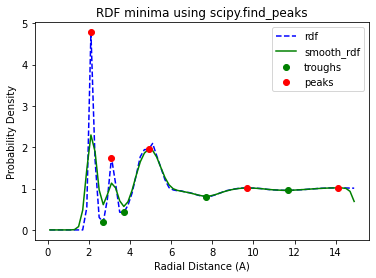

In [10]:
# example rdf plot

easy_rdf_bins = npz_loader(datafiles.easy_rdf_bins["bn_all"])
easy_rdf_data = npz_loader(datafiles.easy_rdf_data["bn_all"])

#find the cutoff point of the RDF
cutoff = identify_cutoff_scipy(easy_rdf_bins, easy_rdf_data)
print(f"solvation radius is {cutoff}")

# plot the result to check
fig, ax = plot_scipy_find_peaks_troughs(easy_rdf_bins, easy_rdf_data)
plt.show()

This approach works very well for RDFs with well defined minima and is the default minima-identifying method used in `solvation_analysis`. Lets now confirm this by going though a typical calculation of solution properties.

In [11]:

# instantiate Universe
u = mda.Universe(datafiles.bn_fec_data, datafiles.bn_fec_dcd_wrap)

# define solute AtomGroup
li_atoms = u.atoms.select_atoms("type 22")

# define solvent AtomGroups
PF6 = u.atoms.select_atoms("byres type 21")
BN = u.atoms.select_atoms("byres type 5")
FEC = u.atoms.select_atoms("byres type 19")

solution = Solution(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC})
# run analysis
solution.run()
solution.radii

/Users/orioncohen/projects/development/solvation-analysis/solvation_analysis/solvation_analysis/solution.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pairs[:, 1] = solvent.ix[[pairs[:, 1]]]


{'PF6': 2.8500000000000005, 'BN': 2.6500000000000004, 'FEC': 2.75}

Here the slight difference between the precomputed **BN** radii and those we have generated using `Solution` is due to the number of frames analysed and can be ignored.

# Using an arbitrary function to find minima on the RDF

Due to the roughness of some RDF data, the univariate spline interpolation and critical point finding algorithms may sometimes fail to find the correct minima (if there even is one). One can either set the radii manually as is done for **PF6** in the basics tutorial, or you can supply a custom function of arbitrary complexity. 

This function must take the RDF and return a single scalar value (the minima). Lets try a different function for our **PF6** problem case. 

Instead of a spline interpolation, lets use some of Scipy's signal processing functionality. In this case we will use `scipy.signal.find_peaks` on the **negated data** to find the minima. We also require that the peaks have a distance of **5 samples** between them with the `distance=5` kwarg.

Lets try it on the raw data from our succsessful spline interpolation first.

In [5]:
# find peaks using scipy
peaks, _  = find_peaks(-easy_rdf_data, distance=5)


solvation radius is 2.7


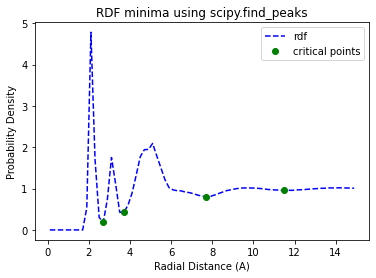

In [6]:
plt.plot(easy_rdf_bins, easy_rdf_data, "b--", label="rdf")
plt.plot(easy_rdf_bins[peaks], easy_rdf_data[peaks], "go", label="critical points")
plt.xlabel("Radial Distance (A)")
plt.ylabel("Probability Density")
plt.title("RDF minima using scipy.find_peaks")
plt.legend()

print(f"solvation radius is {easy_rdf_bins[peaks[0]]}")
plt.show()

This looks great! Our result is very close to our previous spline interpolation. Now lets try with our challenging PF6 case.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84b393a280>)

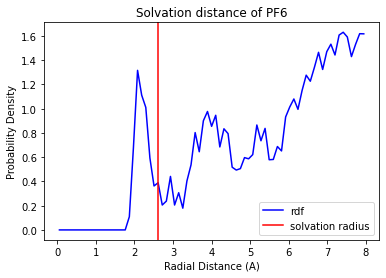

In [7]:
pf6_bins, pf6_data = solution.rdf_data["PF6"]
solution.plot_solvation_radius('PF6')

That looks more challenging. So why does it have a nice red line? 

Remember that we manuall set the solvation radii for PF6 with:

```python
solution.radii['PF6'] = 2.6

```

Lets try a whole new solution **using our scipy peak finding function** instead of the default spline. 

First we need to **wrap our function** so that it matches the call signature in our solution code (takes `bins` and `data` as arguments) and the functionality we want:

Remember that our function must return the radii at the **first minima** as a float and that find_peaks requires the **negated** data to find minima rather than maxima.


In [8]:
def find_peaks_wrapper(bins, data, **kwargs):
    peaks, _  = find_peaks(-data, **kwargs)
    radii = bins[peaks[0]]
    return radii
    

Notice we passed our `**kwargs` to the the find peaks function. This can be combined with the `kernel_kwargs` argument to `Solution` to pass arbitrary flags to your method. 

In [9]:
solution_scipy_peak = Solution(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC}, rdf_kernel=find_peaks_wrapper, kernel_kwargs={"distance": 5})
solution_scipy_peak.run()

{'PF6': 2.72, 'BN': 2.6133333333333333, 'FEC': 2.6133333333333333}


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84b303e910>)

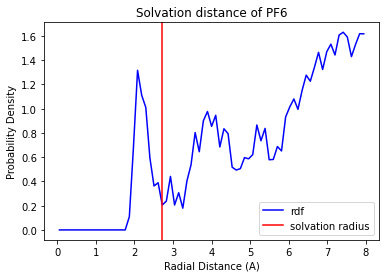

In [10]:
print(solution_scipy_peak.radii)
solution_scipy_peak.plot_solvation_radius('PF6')

Fantastic work! We have now found a function that can find our troublesome **PF6** minima.

Now you know how to write your own custom functions and wrappers to  calculate solvation radii however you like. The possibilities are endless!